**Data Description**


*Research question*

We are studying projects on the platform gofundme and the diverse factors that lead a project to be found. In our data set, we have extract the name, the date of the project, the description, the category, the pourcentage raised, the number of donors etc… 

Here are the questions we want to answer : 
- Does the category have an influence on the founding ? 
- Does the  pourcentage raised intuitively increase with time ? 
- Do Keywords in the description make a project more attractive ? 
- Does the donation per user influence the foundation ?


In [1]:
#Useful imports 
import time
time_duration = 0.5
import requests
from bs4 import BeautifulSoup

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv("DataFinalfromWebScraping2.csv")


### II/CLEANING DATA

<b>II.1/We transform Creation Date to a datetime </b>

For this we will tokenize the str sentence Creation Date, create a dictionary for month and transform Created 2 days ago in 2022-01-14 for example with the function Convertdate. 

Then, we transform it in a proper DateTime

In [3]:
from datetime import date

#We use nltk to tokenize the str of Creation Date
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/albandhauthuille/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
def monthToNum(shortMonth):
    return {
            'January': 1,
            'February': 2,
            'March': 3,
            'April': 4,
            'May': 5,
            'June': 6,
            'July': 7,
            'August': 8,
            'September': 9, 
            'October': 10,
            'November': 11,
            'December': 12
    }[shortMonth]

In [5]:
def Convertdate():

    new_Date=[]
    #print(new_Date)
    for i in range (df['Creation Date'].size):
        #print(i)
        Creation_date = word_tokenize(df['Creation Date'][i])
        #print(Creation_date)
        
        if 'now'in Creation_date or 'hours' in Creation_date:
            new_Date.append(str(str(2022)+'-'+'01'+'-'+str(24)))
        elif 'ago' not in Creation_date: 
            #print('no')
            new_Date.append(str(Creation_date[4])+'-'+str(monthToNum(Creation_date[1]))+'-'+str(Creation_date[2]))
        
            
        elif 'ago' in Creation_date: 
            new_Date.append(str(str(2022)+'-'+'01'+'-'+str(24-int(Creation_date[1]))))
    return new_Date

In [6]:
df['Creation Date']=Convertdate()

In [7]:
pd.to_datetime(df['Creation Date'])
df['Creation Date']=pd.to_datetime(df['Creation Date'])


<b>II.2/ Retiring the '%' of Pourcentage Raised to plot properly

In [8]:
pd.options.mode.chained_assignment = None  # default='warn'
for i in range(len(df['Pourcentage Raised'])):
    df['Pourcentage Raised'][i]=df['Pourcentage Raised'][i][:-1]

In [9]:
#For example:
df['Pourcentage Raised'][4]

'1.0'

<b>II.3/ Convert to proper type

In [10]:
df=df.convert_dtypes()


In [11]:
df['Pourcentage Raised']=df['Pourcentage Raised'].astype(float)
df

,Unnamed: 0,title,Categorie,collect,town,Pourcentage Raised,Creation Date,Description,NumberDonors
0,0,aider arta se soigner du cancer,"Medical, Illness & Healing","€1,457 raised of €50,000",Annecy,2.9,2022-01-21,"APPEL A L'AIDEChers amis, camarades, humaniste...",44
1,1,soutien ffs pour simone,"Medical, Illness & Healing","€1,952 raised of €1,900",Aubervilliers,100.0,2022-01-08,"{*english below*}Ce 18 janvier, je célèbre mes...",61
2,2,help a mom in coma wake up again,"Medical, Illness & Healing","€6,065 raised of €1",Metz,100.0,2022-01-11,"Your support is needed !A Mum of six, 58 years...",130
3,3,aidez gladys pour un ultime traitement,"Medical, Illness & Healing","€5,207 raised of €100,000",Héricy,5.2,2022-01-14,«Tout le monde est faible devant la souffrance...,50
4,4,aidez donner naima une autre chance de vie,"Medical, Illness & Healing","€630 raised of €110,000",Marseille,1.0,2022-01-14,Bonjour à tous Nous sollicitons votre générosi...,19
...,...,...,...,...,...,...,...,...,...
1723,1723,mvfdp4 i just wanna be a millionaire,"Dreams, Hopes & Wishes",€0 raised of €1.0M,Nice,1.0,2022-01-14,50 cents from you could change my life.Please ...,0
1724,1724,bring a smile to the unfortunate,"Dreams, Hopes & Wishes","€0 raised of €100,000","Sainte-Rose, La Réunion",1.0,2022-01-14,"Hi, My name is Jayson,We are a group of anony...",0
1725,1725,testv55,"Dreams, Hopes & Wishes",€0 raised of €200,Sully-sur-Loire,1.0,2022-01-14,Covid - Omicron : quel est ce symptômeRead more,0
1726,1726,weekend final,"Dreams, Hopes & Wishes",€0 raised of €300,Poitiers,1.0,2022-01-13,"Bonjour, C'est le week-end Final après sa ferm...",0


<b>II.4/ Duration of a collect


In [12]:
Duration =[]
for i in range(len(df['Creation Date'])):
    Duration.append((pd.Timestamp.today()-df['Creation Date'][i]).days)
df["Duration in days"]=Duration

<b> II.5/We only study the keywords, so we reduce the 'Description' to a 'Short_description' with with words of lenght>4

In [13]:
Short_description=[]
for i in range(len(df['Description'])):
    list=[]
    a=word_tokenize(df['Description'][i])
    for word in a:
        if len(word)>4:
            list.append(word)
    Short_description.append(list)

df['Short_description']=Short_description
df

,Unnamed: 0,title,Categorie,collect,town,Pourcentage Raised,Creation Date,Description,NumberDonors,Duration in days,Short_description
0,0,aider arta se soigner du cancer,"Medical, Illness & Healing","€1,457 raised of €50,000",Annecy,2.9,2022-01-21,"APPEL A L'AIDEChers amis, camarades, humaniste...",44,4,"[APPEL, L'AIDEChers, camarades, humanistes, fa..."
1,1,soutien ffs pour simone,"Medical, Illness & Healing","€1,952 raised of €1,900",Aubervilliers,100.0,2022-01-08,"{*english below*}Ce 18 janvier, je célèbre mes...",61,17,"[english, below, janvier, célèbre, ans.Il, com..."
2,2,help a mom in coma wake up again,"Medical, Illness & Healing","€6,065 raised of €1",Metz,100.0,2022-01-11,"Your support is needed !A Mum of six, 58 years...",130,14,"[support, needed, years, coma.She, hospitalize..."
3,3,aidez gladys pour un ultime traitement,"Medical, Illness & Healing","€5,207 raised of €100,000",Héricy,5.2,2022-01-14,«Tout le monde est faible devant la souffrance...,50,11,"[monde, faible, devant, souffrance, Alors, cac..."
4,4,aidez donner naima une autre chance de vie,"Medical, Illness & Healing","€630 raised of €110,000",Marseille,1.0,2022-01-14,Bonjour à tous Nous sollicitons votre générosi...,19,11,"[Bonjour, sollicitons, votre, générosité, notr..."
...,...,...,...,...,...,...,...,...,...,...,...
1723,1723,mvfdp4 i just wanna be a millionaire,"Dreams, Hopes & Wishes",€0 raised of €1.0M,Nice,1.0,2022-01-14,50 cents from you could change my life.Please ...,0,11,"[cents, could, change, life.Please, dream, tru..."
1724,1724,bring a smile to the unfortunate,"Dreams, Hopes & Wishes","€0 raised of €100,000","Sainte-Rose, La Réunion",1.0,2022-01-14,"Hi, My name is Jayson,We are a group of anony...",0,11,"[Jayson, group, anonymous, volunteers, profita..."
1725,1725,testv55,"Dreams, Hopes & Wishes",€0 raised of €200,Sully-sur-Loire,1.0,2022-01-14,Covid - Omicron : quel est ce symptômeRead more,0,11,"[Covid, Omicron, symptômeRead]"
1726,1726,weekend final,"Dreams, Hopes & Wishes",€0 raised of €300,Poitiers,1.0,2022-01-13,"Bonjour, C'est le week-end Final après sa ferm...",0,12,"[Bonjour, C'est, week-end, Final, après, ferme..."


<b> II.6.1/ Creation of column 'Amount Collected'

In [14]:
Amount_Collected=[]
#print(df)
for i in range(len(df['collect'])):
    #word=(df['collect'][i])[1:]
    word=word_tokenize(df['collect'][i][1:])
    #If the amount is about millions:
    
    if 'M' in word[0]: 
        Amount_Collected.append(float(word[0].replace(',', '.')[:-1])*1000000)
    #print(word)
    else:
        if ',' in word[0]:
            Amount_Collected.append(float(word[0].replace(',', '.'))*1000)
        else:
            Amount_Collected.append(float(word[0].replace(',', '.')))
            
df['Amount collected ']=Amount_Collected

<b> II.6.2/ Creation of Column 'Amount targeted'

In [15]:
Amount_Targeted=[]
for i in range(len(df['collect'])):
    word=word_tokenize(df['collect'][i])
    #print(word)
    #If the amount is about millions:
    if 'M' in word[-1]: 
        Amount_Targeted.append(float(((word[-1].replace('M', '')).replace('€','')).replace('£',''))*1000000)
    #print(word)
    elif 'B' in word[-1]: 
        Amount_Targeted.append(float(((word[-1].replace('B', '')).replace('€','')).replace('£',''))*1000000000)
    else:
        if ',' in word[-1]:
            Amount_Targeted.append(float(((word[-1].replace(',', '.')).replace('€','')).replace('£',''))*1000)
        else:
            Amount_Targeted.append(float(((word[-1].replace(',', '.')).replace('€','')).replace('£','')))
            
#len(Amount_Targeted)
df['Amount targeted']=Amount_Targeted

   <B> II.7/ MeanDonation

In [16]:
MeanDonation =[]
for i in range(len(df['NumberDonors'])):
    if df['NumberDonors'][i]>0:
        MeanDonation.append((df['Amount collected '][i])/(df['NumberDonors'][i]))
    else : MeanDonation.append(0)
df['MeanDonation']=MeanDonation


<b>II.8/ Categories and conversion to numeric to plot and corr properly

In [17]:
catégorie = ["Medical, Illness & Healing", "Funerals & Memorials", "Accidents & Emergencies","Non-Profits & Charities","Education & Learning", "Animals & Pets", "Environment", "Business & Entrepreneurs","Community & Neighbors", "Competitions & Pageants","Creative Arts, Music & Film", "Celebrations & Events","Missions, Faith & Church", "Babies, Kids & Family", "Sports, Teams & Clubs", "Travel & Adventure","Volunteer & Service", "Dreams, Hopes & Wishes", "Other"]
#print(catégorie)




In [18]:
df['categoryNumeric'] = pd.factorize(df['Categorie'])[0] + 1
df['townNumeric'] = pd.factorize(df['town'])[0] + 1

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Unnamed: 0          1728 non-null   Int64         
 1   title               1728 non-null   string        
 2   Categorie           1728 non-null   string        
 3   collect             1728 non-null   string        
 4   town                1728 non-null   string        
 5   Pourcentage Raised  1728 non-null   float64       
 6   Creation Date       1728 non-null   datetime64[ns]
 7   Description         1728 non-null   string        
 8   NumberDonors        1728 non-null   Int64         
 9   Duration in days    1728 non-null   int64         
 10  Short_description   1728 non-null   object        
 11  Amount collected    1728 non-null   float64       
 12  Amount targeted     1728 non-null   float64       
 13  MeanDonation        1728 non-null   float64     

### III/ First Analysis

<b>III.1. First look 

In [20]:
df.describe()

,Unnamed: 0,Pourcentage Raised,NumberDonors,Duration in days,Amount collected,Amount targeted,MeanDonation,categoryNumeric,townNumeric
count,1728.000000,1728.00000,1728.000000,1728.00000,1.728000e+03,1.728000e+03,1728.000000,1728.000000,1728.000000
mean,863.500000,22.10787,85.384259,56.33044,7.450310e+03,3.493280e+06,39.468118,9.498264,309.004051
std,498.974949,32.37733,1174.531989,69.87727,9.808869e+04,5.711015e+07,102.427454,5.191972,278.631818
min,0.000000,1.00000,0.000000,1.00000,0.000000e+00,1.000000e+00,0.000000,1.000000,1.000000
25%,431.750000,1.00000,0.000000,12.00000,0.000000e+00,1.000000e+03,0.000000,5.000000,41.750000
50%,863.500000,2.95000,3.000000,37.00000,9.000000e+01,3.000000e+03,20.000000,9.500000,227.000000
75%,1295.250000,30.45000,16.000000,68.00000,6.887500e+02,1.000000e+04,46.666667,14.000000,530.250000
max,1727.000000,100.00000,44392.000000,366.00000,3.300000e+06,1.000000e+09,2950.962963,18.000000,911.000000


In [21]:
df.corr()

,Unnamed: 0,Pourcentage Raised,NumberDonors,Duration in days,Amount collected,Amount targeted,MeanDonation,categoryNumeric,townNumeric
Unnamed: 0,1.000000,-0.236096,-0.045198,0.053928,-0.057343,0.075547,-0.126093,0.998385,0.448352
Pourcentage Raised,-0.236096,1.000000,0.112374,0.022336,0.117099,-0.039527,0.247021,-0.227938,-0.091195
NumberDonors,-0.045198,0.112374,1.000000,0.008824,0.922988,-0.002119,0.033937,-0.050347,0.008070
Duration in days,0.053928,0.022336,0.008824,1.000000,0.021402,-0.025243,0.082175,0.044506,-0.053951
Amount collected,-0.057343,0.117099,0.922988,0.021402,1.000000,-0.002209,0.121436,-0.059323,0.000662
Amount targeted,0.075547,-0.039527,-0.002119,-0.025243,-0.002209,1.000000,-0.020229,0.075316,0.008329
MeanDonation,-0.126093,0.247021,0.033937,0.082175,0.121436,-0.020229,1.000000,-0.123249,-0.046024
categoryNumeric,0.998385,-0.227938,-0.050347,0.044506,-0.059323,0.075316,-0.123249,1.000000,0.444520
townNumeric,0.448352,-0.091195,0.008070,-0.053951,0.000662,0.008329,-0.046024,0.444520,1.000000


In [22]:
for e in catégorie:
    print(e)
    print('\n')
    print(df.loc[df['Categorie']==e].describe())
    print('\n')
    print('\n')


Medical, Illness & Healing


       Unnamed: 0  Pourcentage Raised  NumberDonors  Duration in days  \
count   97.000000           97.000000     97.000000         97.000000   
mean    50.072165           26.856701    182.432990         40.474227   
std     37.545597           30.696284   1516.492457         33.596284   
min      0.000000            1.000000      1.000000          1.000000   
25%     24.000000            3.800000      8.000000         14.000000   
50%     48.000000           13.200000     15.000000         40.000000   
75%     72.000000           41.000000     29.000000         55.000000   
max    297.000000          100.000000  14960.000000        253.000000   

       Amount collected   Amount targeted  MeanDonation  categoryNumeric  \
count          97.000000     9.700000e+01     97.000000             97.0   
mean         9054.515464     4.442945e+04     54.148241              1.0   
std         73222.610124     3.041569e+05     58.439691              0.0   
min      

max     797.000000  




Travel & Adventure


        Unnamed: 0  Pourcentage Raised  NumberDonors  Duration in days  \
count    96.000000           96.000000     96.000000         96.000000   
mean   1487.500000            9.035417      3.708333         45.250000   
std      27.856777           24.962595     13.415558         41.021945   
min    1440.000000            1.000000      0.000000          1.000000   
25%    1463.750000            1.000000      0.000000         15.000000   
50%    1487.500000            1.000000      0.000000         44.000000   
75%    1511.250000            1.000000      0.000000         63.500000   
max    1535.000000          100.000000     81.000000        324.000000   

       Amount collected   Amount targeted  MeanDonation  categoryNumeric  \
count          96.000000     9.600000e+01     96.000000             96.0   
mean          262.895833     1.106615e+07     11.883829             16.0   
std           994.711463     1.021786e+08     40.988366    

<b> III.2/Let's look at the collect of the last month, we will only work on DECEMBER

In [23]:
mask_december = (df['Creation Date'] > '2022-1-1') & (df['Creation Date'] <= '2022-1-31')

mask_SmallCap = (df['Amount targeted']<5000)
mask_MidCap = (df['Amount targeted']>5000)& (df['Amount targeted']<50000)
mask_BigCap=(df['Amount targeted']>50000)

#Collects of december
december=df.loc[mask_december]


<b> III.3/ Relation Duration of the collect and Pourcentage Raised

Text(0, 0.5, 'Pourcentage raised')

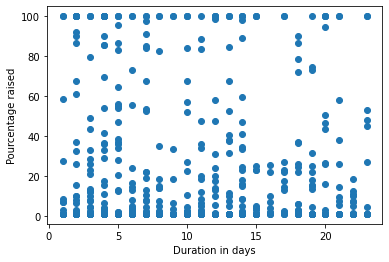

In [24]:
#For all categories
plt.figure()
    
x=december['Duration in days']
y=december['Pourcentage Raised']
    
fig=plt.scatter(x, y )
plt.xlabel('Duration in days')
plt.ylabel('Pourcentage raised')


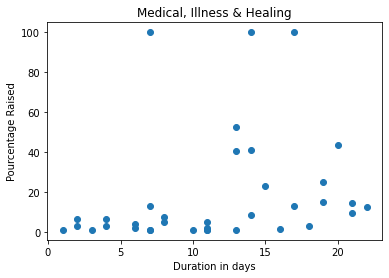

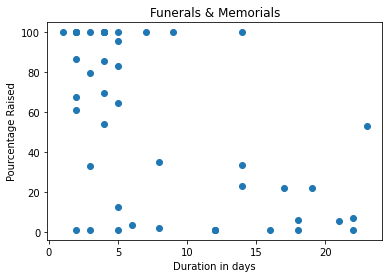

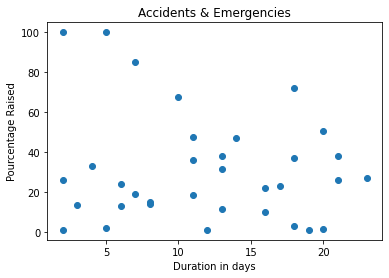

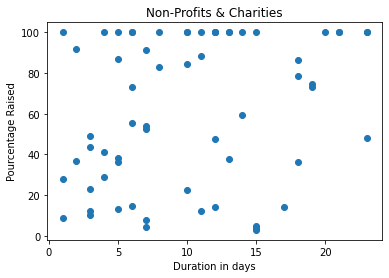

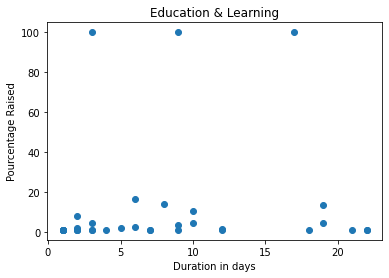

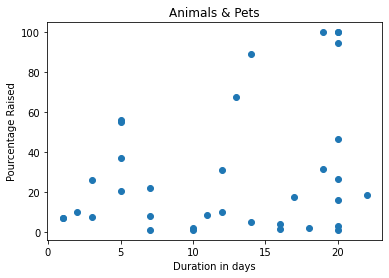

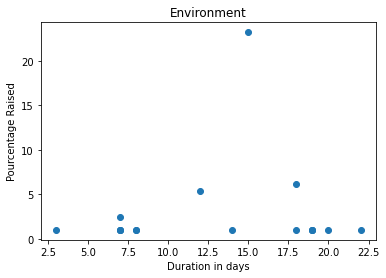

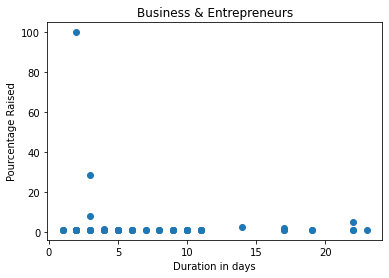

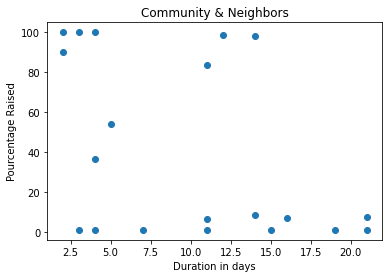

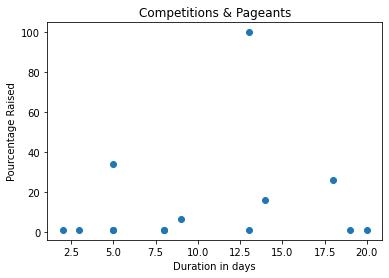

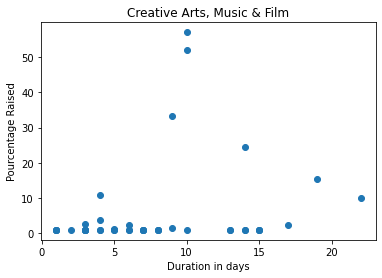

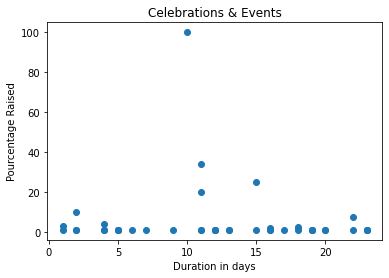

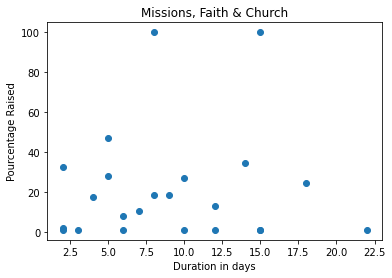

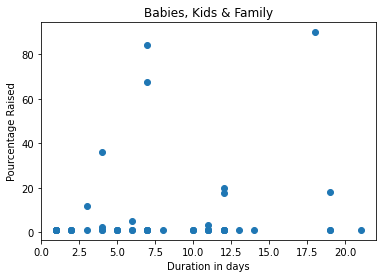

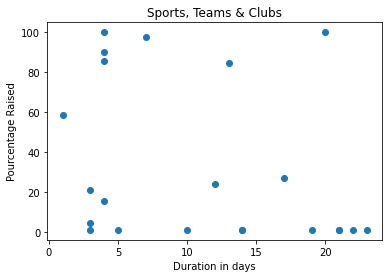

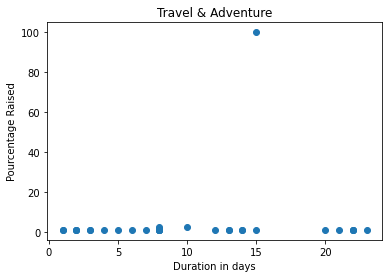

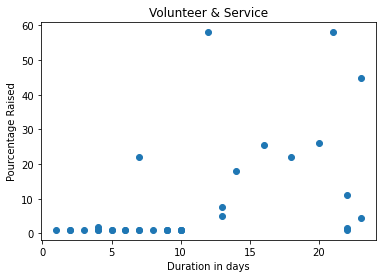

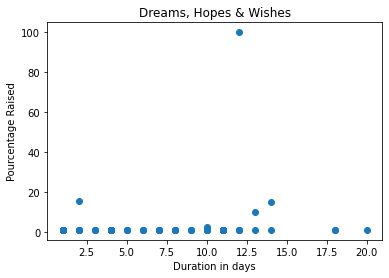

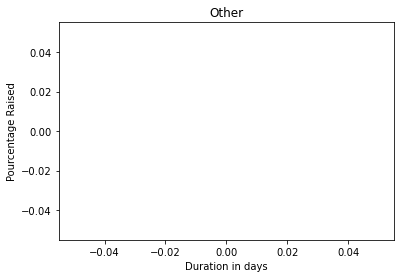

In [25]:
#For each category
for cat in catégorie:
    plt.figure()
    
    x=december.loc[(df['Categorie'] ==cat)]['Duration in days']
    y=december.loc[(df['Categorie'] ==cat)]['Pourcentage Raised']
    
    fig=plt.scatter(x, y )
    plt.title(cat)
    plt.xlabel('Duration in days')
    plt.ylabel('Pourcentage Raised')

 =>No real model between Duration of the collect and Pourcentage Raised

<b> III.4/ Relation between descriptions of projects and Pourcentage Raised

<b> III.4.1/ We make a dictionnary of keywords for each category we will use to study descriptions

In [26]:
#We look at the words with the biggest occurences for each category (open 'occurences' file )
from collections import Counter
txt=[]
for cat in catégorie:
    list1=[]
    for e in df.loc[(df['Categorie'] ==cat)]['Short_description']:
        list1=list1+e
    counts = Counter(list1)
    txt.append(cat)
    txt.append("      ")
    txt.append(counts)


with open('occurences.txt', 'w') as f:
    for item in txt:
        f.write("%s\n" % item)

In [27]:
#We list the words of occurences that are keywords, which means the ones with a signification linked with the category

motsclés1=[[' douleur, association, funds, générosité, surgery, financier, remercie, disease, cancer, traitements, opération, besoin,enfant, mère '], 
[' family, obsèques, children, soutien, remercie, enterrement, hopital, association, community, maman '],
[' typhon, community, home, treatment, soutien, reconstruire, destroyed, maison, father, famille '],
[' support, community, together, children, foundation, students, animal, organization, cause, education, property, building '],
[' school, France, children, formation, yhèse, étude, construction, association, classe, famille '],
[' vétérinaire, opération, chien, frais, traitements, sauver, chimiothérapie, chat, examens, chevaux '],
[ ' association, environnement, société, développement, qualité, paris, climate, change, sensibiliser, scientifique, électricité »'],
[' agricole, communication, restaurant, investissement, agriculture, business, social, objectif, activité, professionnelle '],
[' vaccination, family, community, water, business, needs, health '],
[' compétition, championnat, international, opportunity, formation, passion, métrage, vidéo, réalisation, training ' ],
[ ' association, computer, vidéo, ordinateur, album, montage, formation, documentary ' ],
[ ' festival, conference, transpersonnalité, musique, climate, justice, agreement, anniversaire '],
[ ' mission, community, christ, church, évangélisation, voyage, prayer, christians, orphanages '],
[ ' famille, maison, besoin, place, cancer, association, logement, travaux, children ' ],
[ ' coach, tennis, equipments, soccer, Olympic, academy, club, basketball, soccer, volleyball, ironman ' ],
[ ' voyage, dream, equipment, découvrir, trail, aventure, vidéo, professionnelle, birthday ' ],
[ ' enfants, villages, typhon, association, education, maisons, acheter, christmas, nourrir ' ],
[ ' refugee, voyage, meditation, pédagogique, besoin, school, program '],
[]
          ]
motsclés=[]

for e in motsclés1:
    motsclés.append(word_tokenize(str(e).replace(',','').replace('[','').replace(']','').replace('"','').replace("'" ,'')))
    

In [28]:
#We create a dictionnary linking a category and the keywords linked with it
motclé_dict = []

motclé_dict=dict()
#catégorie is defined in II.8/
for i in range(len(catégorie)):
    motclé_dict[catégorie[i]]=motsclés[i]


<b>III.4.2/ We give for each project a "scoreword": its the occurences of the keywords in its description

In [29]:
#This function counts the occurences of the words of a list1 in another list2.
def countword(list1, list2):
    occu=dict()
    for word in list1:
        #print(word)
        occu[word]=list2.count(word)
    return occu



In [30]:
#This function counts the numbers of matching words from the description (list1) with the keywords of the category(list2)
def scoreWord(index):
    sum=0
    count=countword(motclé_dict[df['Categorie'][index]],df['Short_description'][index])
    for e in count:
        sum+=count[e]
    return sum 


In [31]:
#We create a column scoreword
scoreword=[]
for i in range(len(df['Short_description'])):
    scoreword.append(int(scoreWord(i)))
df['ScoreWord']=scoreword

<b>III.4.3/ Relation between ScoreWord and Pourcentage Raised

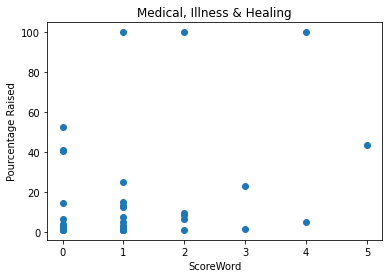

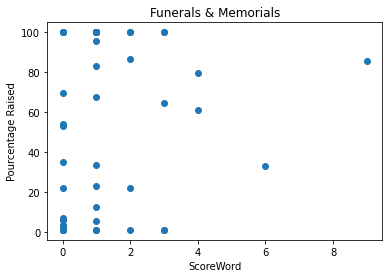

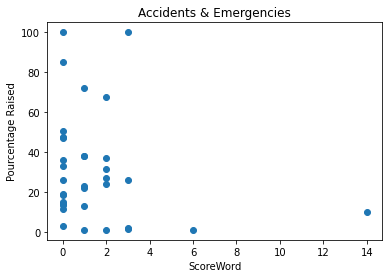

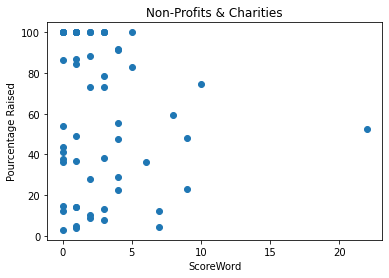

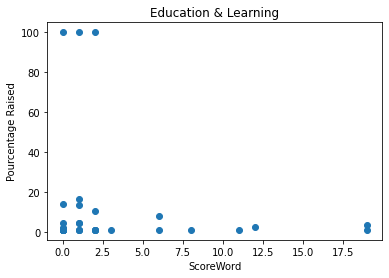

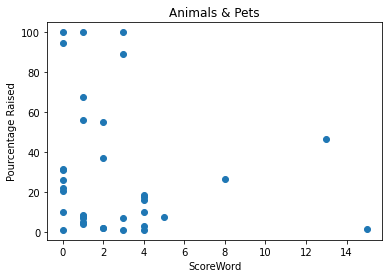

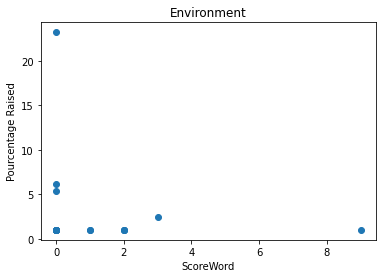

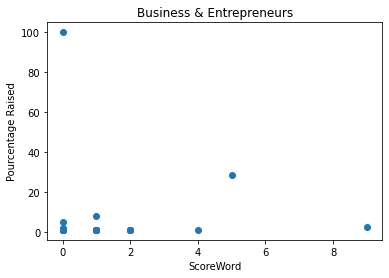

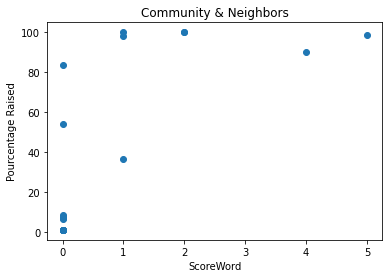

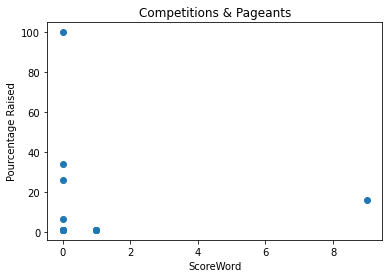

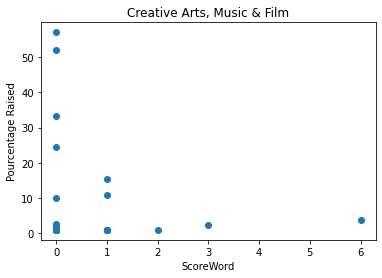

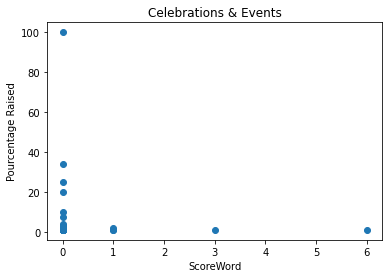

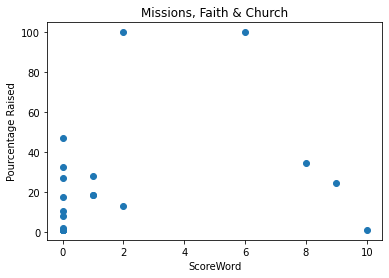

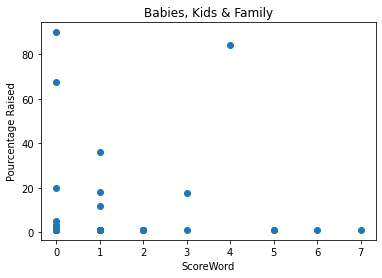

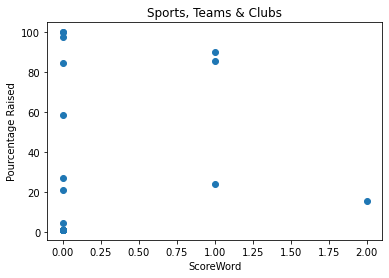

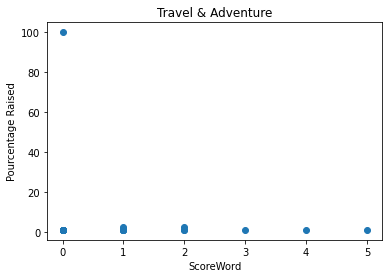

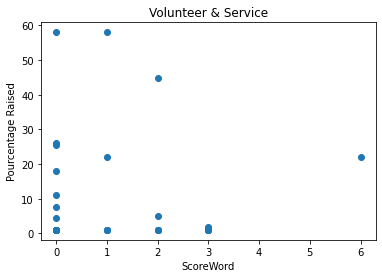

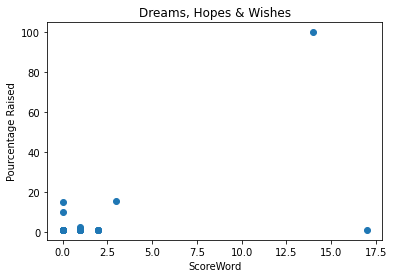

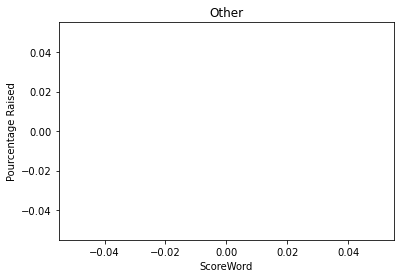

In [32]:
december=df.loc[mask_december]

for cat in catégorie:
    plt.figure()

    x=december.loc[(december['Categorie'] ==cat)]['ScoreWord']
    y=december.loc[(december['Categorie'] ==cat)]['Pourcentage Raised']
    
    fig=plt.scatter(x, y )
    plt.title(cat)
    plt.xlabel('ScoreWord')
    plt.ylabel('Pourcentage Raised')

<b> Relation between Number of Donors and ScoreWord for each category

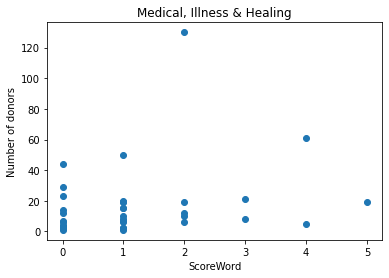

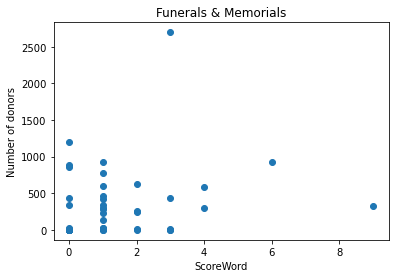

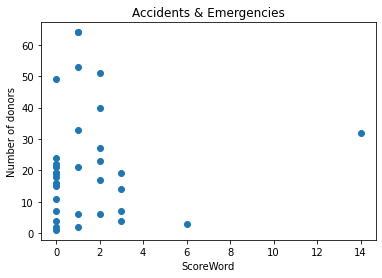

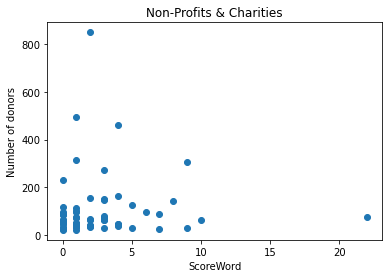

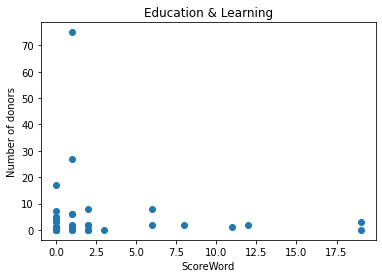

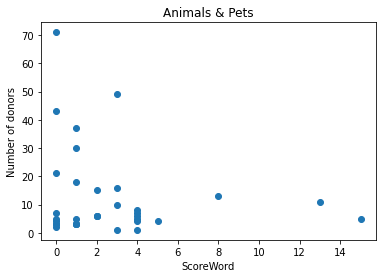

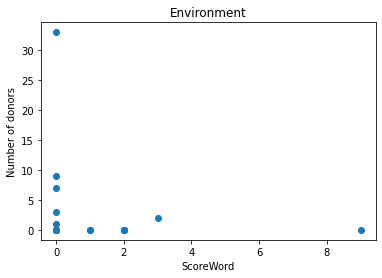

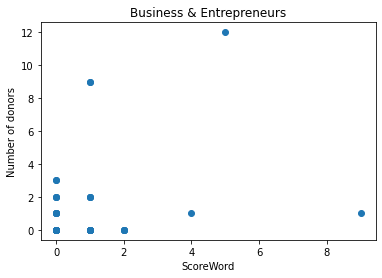

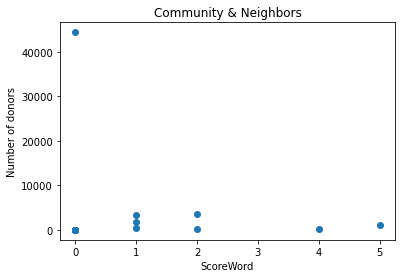

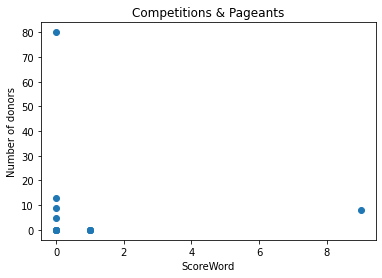

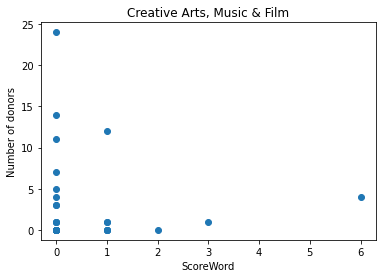

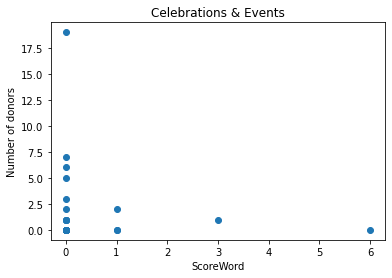

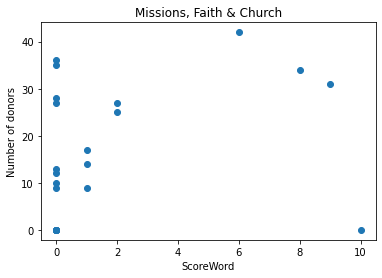

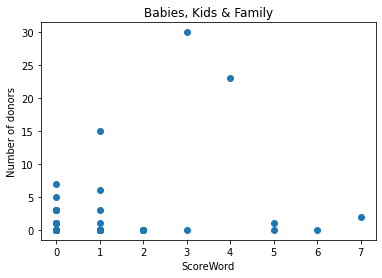

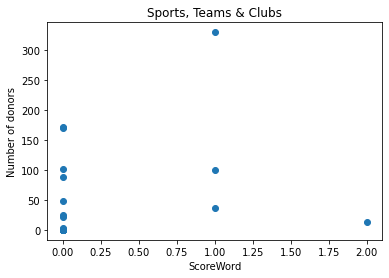

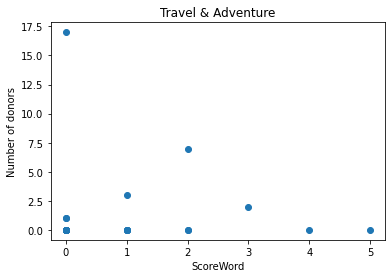

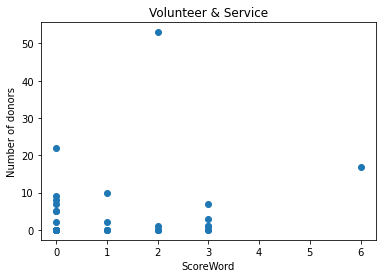

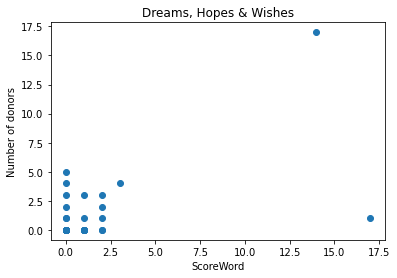

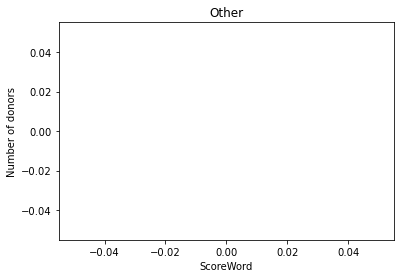

In [33]:

december=df.loc[mask_december]

for cat in catégorie:
    plt.figure()

    x=december.loc[(december['Categorie'] ==cat)]['ScoreWord']
    y=december.loc[(december['Categorie'] ==cat)]['NumberDonors']
    
    fig=plt.scatter(x, y )
    plt.title(cat)
    plt.xlabel('ScoreWord')
    plt.ylabel('Number of donors')

<b> Relation between Duration in days and Number of donors for each category

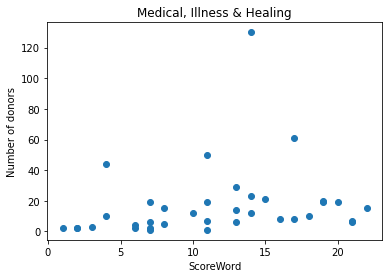

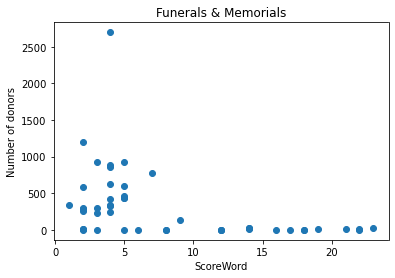

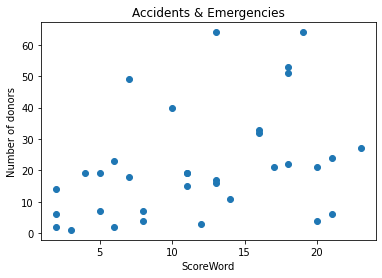

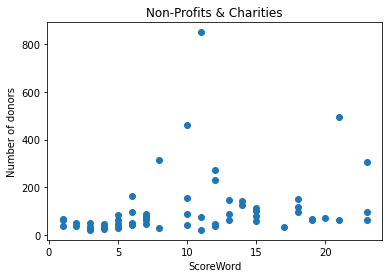

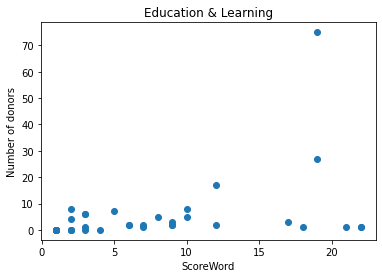

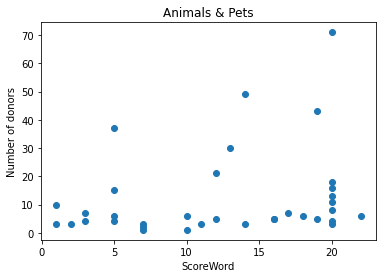

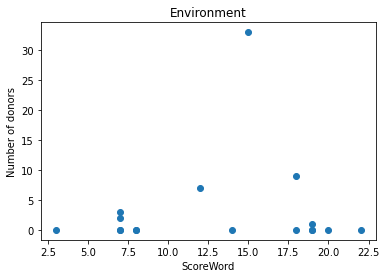

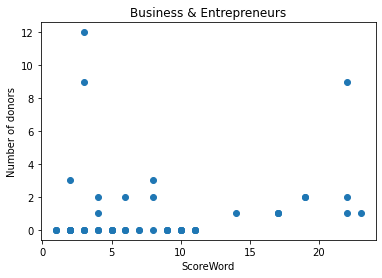

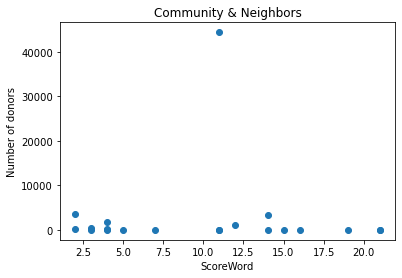

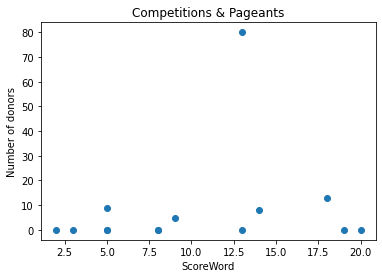

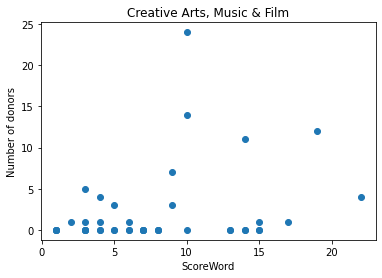

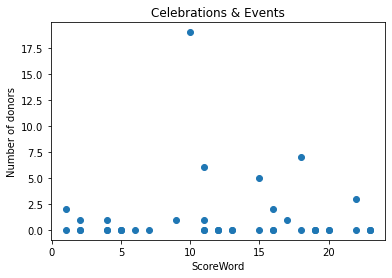

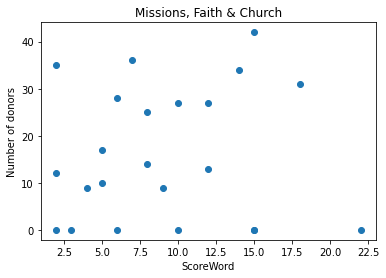

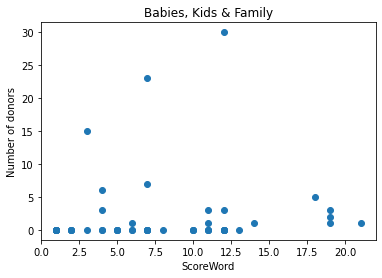

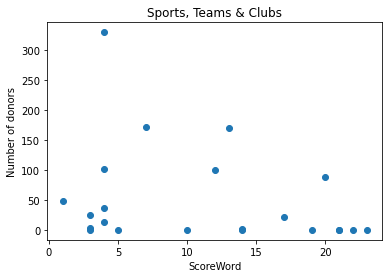

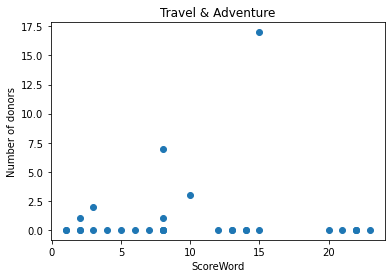

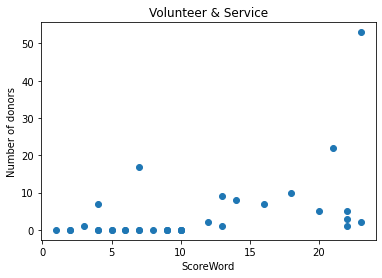

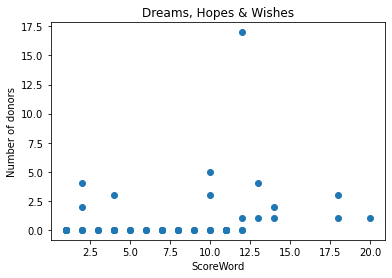

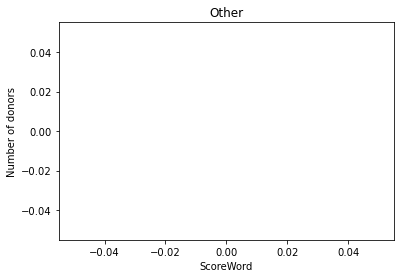

In [34]:
december=df.loc[mask_december]

for cat in catégorie:
    plt.figure()

    x=december.loc[(december['Categorie'] ==cat)]['Duration in days']
    y=december.loc[(december['Categorie'] ==cat)]['NumberDonors']
    
    fig=plt.scatter(x, y )
    plt.title(cat)
    plt.xlabel('ScoreWord')
    plt.ylabel('Number of donors')


<b> Relation between Number of Donors and Amount collected

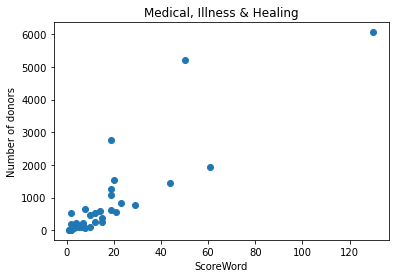

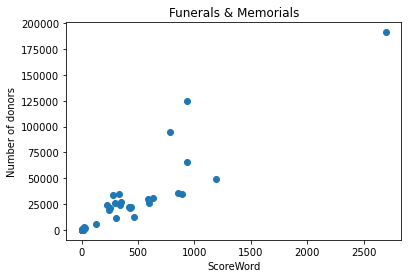

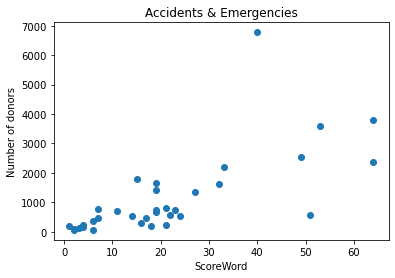

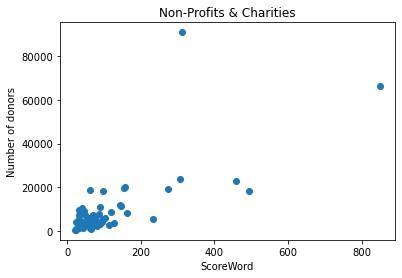

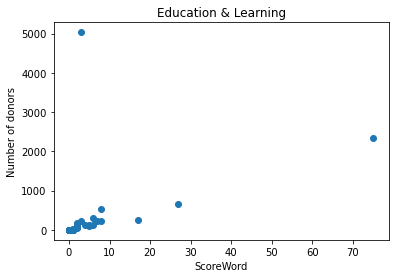

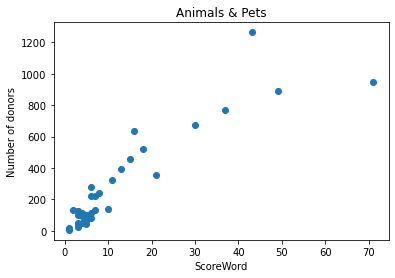

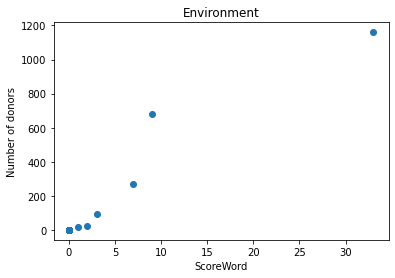

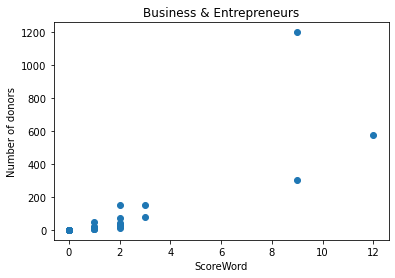

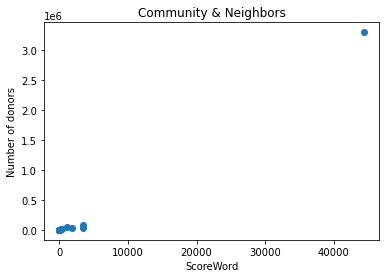

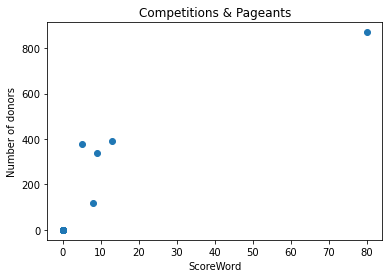

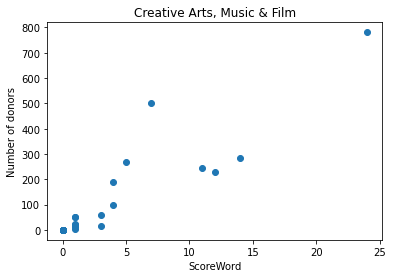

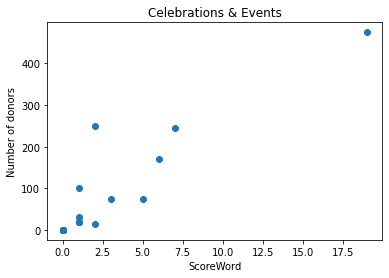

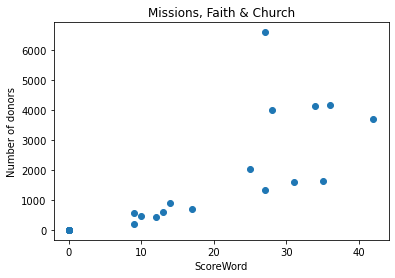

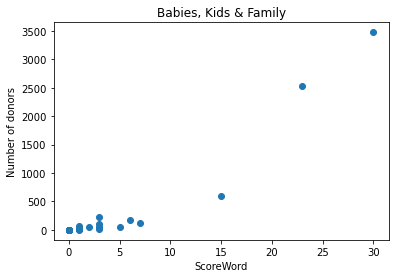

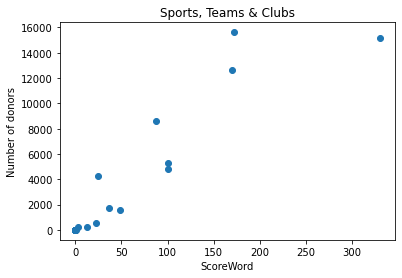

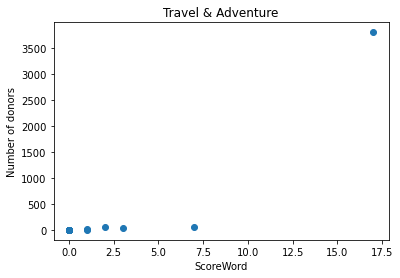

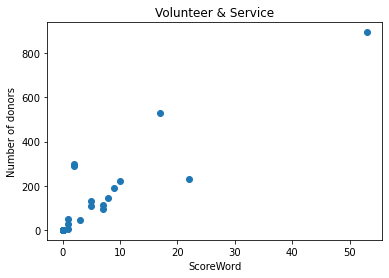

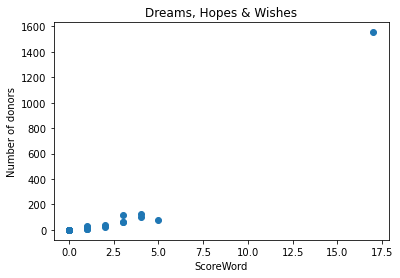

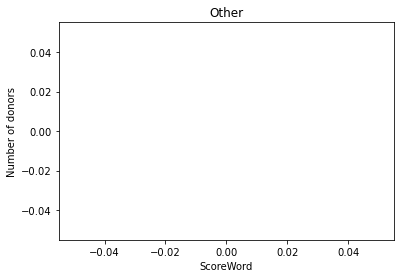

In [35]:
december=df.loc[mask_december]

for cat in catégorie:
    plt.figure()
 

    x=december.loc[(december['Categorie'] ==cat)]['NumberDonors']
    y=december.loc[(december['Categorie'] ==cat)]['Amount collected ']
    
    fig=plt.scatter(x, y )
    plt.title(cat)
    plt.xlabel('ScoreWord')
    plt.ylabel('Number of donors')


<b> Relation between Number of Donors and ScoreWord inside same size projects

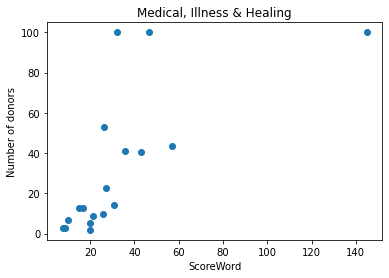

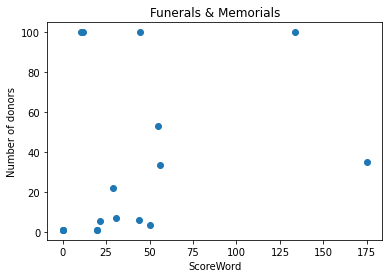

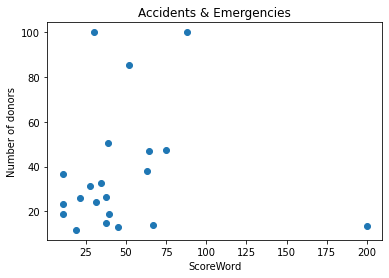

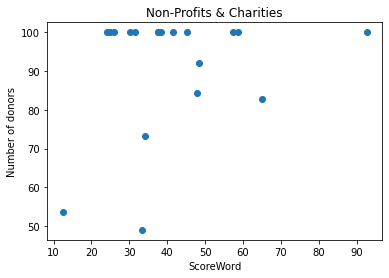

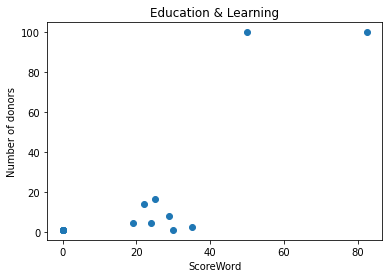

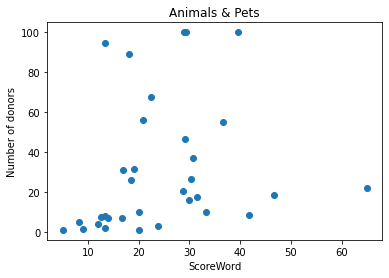

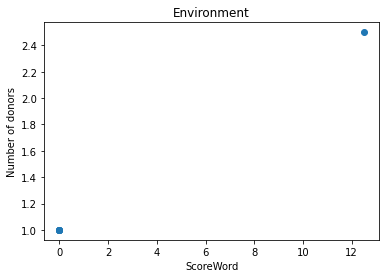

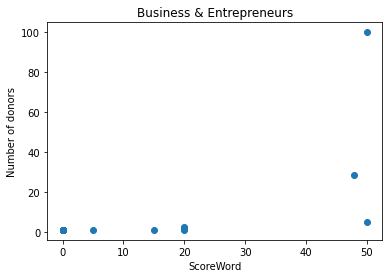

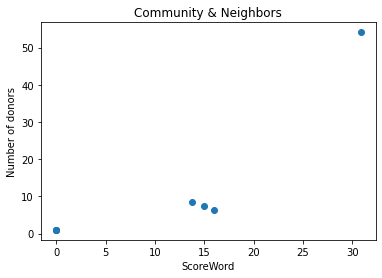

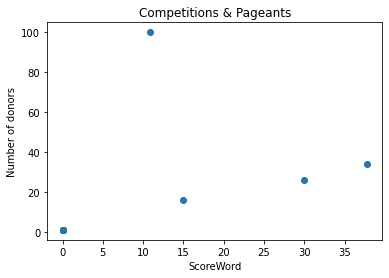

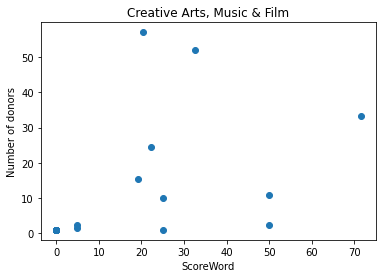

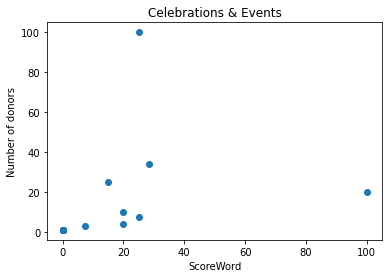

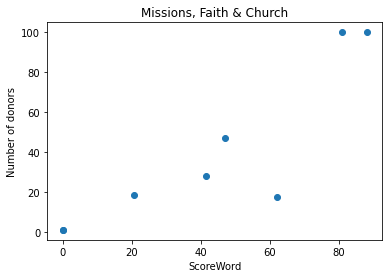

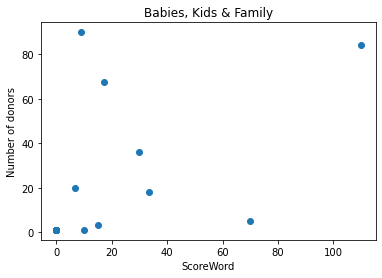

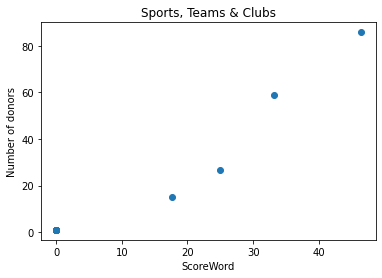

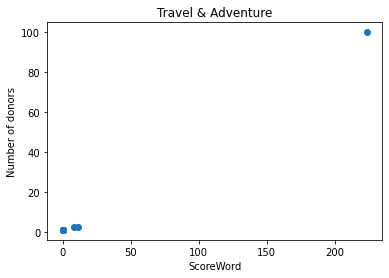

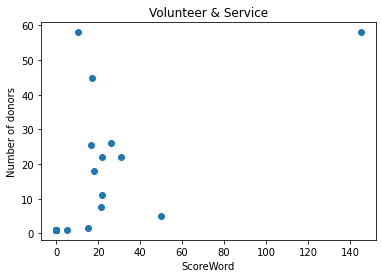

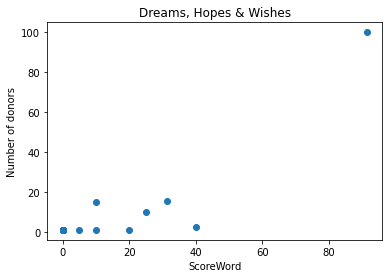

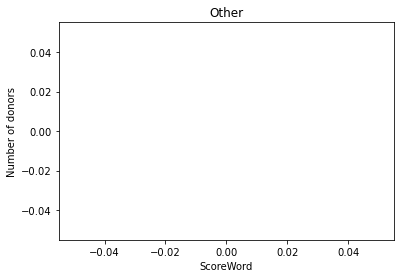

In [36]:
#SmallCap
decemberSmallCap=df.loc[mask_december&mask_SmallCap]
#print(decemberSmallCap.corr())
for cat in catégorie:
    plt.figure()
 

    x=decemberSmallCap.loc[(decemberSmallCap['Categorie'] ==cat)]['MeanDonation']
    y=decemberSmallCap.loc[(decemberSmallCap['Categorie'] ==cat)]['Pourcentage Raised']
    
    fig=plt.scatter(x, y )
    plt.title(cat)
    plt.xlabel('ScoreWord')
    plt.ylabel('Number of donors')


<b> Relation berwwen Pourcentage Raised and MeanDonation for each cap
    

,Unnamed: 0,Pourcentage Raised,NumberDonors,Duration in days,Amount collected,Amount targeted,MeanDonation,categoryNumeric,townNumeric,ScoreWord
Unnamed: 0,1.000000,-0.399011,-0.282834,-0.108535,-0.272957,-0.229545,-0.349844,0.998403,0.528655,-0.124959
Pourcentage Raised,-0.399011,1.000000,0.570283,0.102381,0.614059,0.062775,0.575202,-0.387048,-0.145016,0.154265
NumberDonors,-0.282834,0.570283,1.000000,0.148741,0.940682,0.143667,0.208286,-0.280630,-0.096483,0.058714
Duration in days,-0.108535,0.102381,0.148741,1.000000,0.122893,0.078624,0.073083,-0.105449,-0.119439,0.121605
Amount collected,-0.272957,0.614059,0.940682,0.122893,1.000000,0.198289,0.371615,-0.270712,-0.089499,0.081912
Amount targeted,-0.229545,0.062775,0.143667,0.078624,0.198289,1.000000,0.208037,-0.225537,-0.083730,0.195018
MeanDonation,-0.349844,0.575202,0.208286,0.073083,0.371615,0.208037,1.000000,-0.338431,-0.162525,0.158793
categoryNumeric,0.998403,-0.387048,-0.280630,-0.105449,-0.270712,-0.225537,-0.338431,1.000000,0.522197,-0.118580
townNumeric,0.528655,-0.145016,-0.096483,-0.119439,-0.089499,-0.083730,-0.162525,0.522197,1.000000,-0.046952
ScoreWord,-0.124959,0.154265,0.058714,0.121605,0.081912,0.195018,0.158793,-0.118580,-0.046952,1.000000


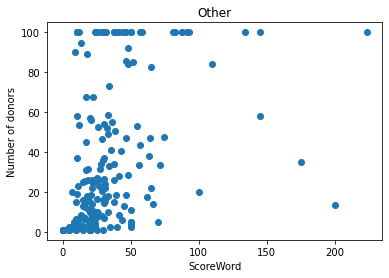

In [37]:
#SmallCap
decemberSmallCap=df.loc[mask_december&mask_SmallCap]
plt.figure()
 

x=decemberSmallCap['MeanDonation']
y=decemberSmallCap['Pourcentage Raised']
    
fig=plt.scatter(x, y )
plt.title(cat)
plt.xlabel('ScoreWord')
plt.ylabel('Number of donors')


decemberSmallCap.corr()


,Unnamed: 0,Pourcentage Raised,NumberDonors,Duration in days,Amount collected,Amount targeted,MeanDonation,categoryNumeric,townNumeric,ScoreWord
Unnamed: 0,1.000000,-0.219787,0.000348,-0.191494,-0.004742,0.325467,-0.545189,0.998363,0.519797,-0.308450
Pourcentage Raised,-0.219787,1.000000,0.400304,-0.092646,0.385324,-0.103601,0.459672,-0.230210,0.082650,0.195202
NumberDonors,0.000348,0.400304,1.000000,0.035005,0.997585,-0.038764,0.101394,-0.010118,0.134935,-0.082512
Duration in days,-0.191494,-0.092646,0.035005,1.000000,0.045787,-0.125230,0.000220,-0.178616,-0.045368,-0.022870
Amount collected,-0.004742,0.385324,0.997585,0.045787,1.000000,-0.036612,0.120569,-0.014327,0.121935,-0.088408
Amount targeted,0.325467,-0.103601,-0.038764,-0.125230,-0.036612,1.000000,-0.143536,0.333149,-0.088372,-0.183247
MeanDonation,-0.545189,0.459672,0.101394,0.000220,0.120569,-0.143536,1.000000,-0.546992,-0.210815,0.222160
categoryNumeric,0.998363,-0.230210,-0.010118,-0.178616,-0.014327,0.333149,-0.546992,1.000000,0.512736,-0.318143
townNumeric,0.519797,0.082650,0.134935,-0.045368,0.121935,-0.088372,-0.210815,0.512736,1.000000,-0.062880
ScoreWord,-0.308450,0.195202,-0.082512,-0.022870,-0.088408,-0.183247,0.222160,-0.318143,-0.062880,1.000000


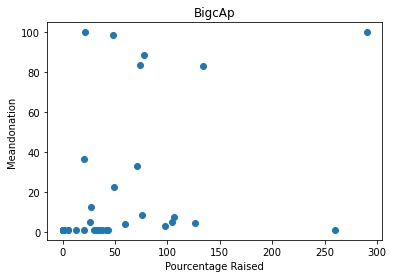

In [38]:
#BigCap
decemberBigCap=df.loc[mask_december&mask_BigCap]
plt.figure()
 

x=decemberBigCap['MeanDonation']
y=decemberBigCap['Pourcentage Raised']
    
fig=plt.scatter(x, y )
plt.title('BigcAp')
plt.xlabel('Pourcentage Raised')
plt.ylabel('Meandonation')


decemberBigCap.corr()


,Unnamed: 0,Pourcentage Raised,NumberDonors,Duration in days,Amount collected,Amount targeted,MeanDonation,categoryNumeric,townNumeric,ScoreWord
Unnamed: 0,1.000000,-0.336653,-0.142380,-0.001731,-0.332635,0.018428,-0.298328,0.998192,0.558099,-0.179021
Pourcentage Raised,-0.336653,1.000000,0.511479,-0.050785,0.879013,0.035725,0.536859,-0.355597,-0.122648,0.063950
NumberDonors,-0.142380,0.511479,1.000000,-0.037458,0.708378,0.225769,0.059112,-0.156200,-0.026966,-0.019471
Duration in days,-0.001731,-0.050785,-0.037458,1.000000,-0.129860,-0.131904,0.103832,0.012318,-0.021303,0.082737
Amount collected,-0.332635,0.879013,0.708378,-0.129860,1.000000,0.200214,0.390574,-0.352957,-0.140713,0.043328
Amount targeted,0.018428,0.035725,0.225769,-0.131904,0.200214,1.000000,0.059991,0.012163,-0.023866,-0.027334
MeanDonation,-0.298328,0.536859,0.059112,0.103832,0.390574,0.059991,1.000000,-0.297528,-0.209073,0.163317
categoryNumeric,0.998192,-0.355597,-0.156200,0.012318,-0.352957,0.012163,-0.297528,1.000000,0.553124,-0.178921
townNumeric,0.558099,-0.122648,-0.026966,-0.021303,-0.140713,-0.023866,-0.209073,0.553124,1.000000,-0.093825
ScoreWord,-0.179021,0.063950,-0.019471,0.082737,0.043328,-0.027334,0.163317,-0.178921,-0.093825,1.000000


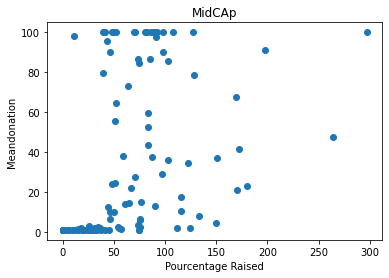

In [51]:
#SmallCap
decemberMidCap=df.loc[mask_december&mask_MidCap]
plt.figure()
 

x=decemberMidCap['MeanDonation']
y=decemberMidCap['Pourcentage Raised']
    
fig=plt.scatter(x, y )
plt.title('MidCAp')
plt.xlabel('Pourcentage Raised')
plt.ylabel('Meandonation')


decemberMidCap.corr()


<b> OLS regression because strong correlation betwen NumberDonors and Amount collected

0.8848828208290608


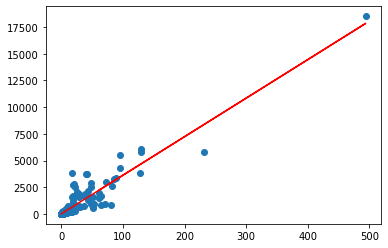

In [53]:
from sklearn import linear_model


X=decemberSmallCap[['NumberDonors']]
y=decemberSmallCap["Amount collected "]

model=linear_model.LinearRegression()
results=model.fit(X,y)

y_pred = model.predict(X)
plt.scatter(X,y)
plt.plot(X,y_pred,color='r')

print(results.score(X, y, sample_weight=None))

0.5017990505749772


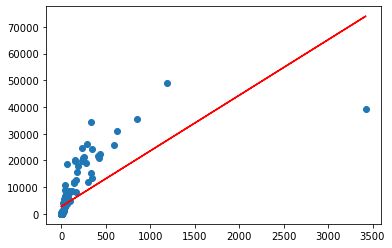

In [48]:
from sklearn import linear_model


X=decemberMidCap[['NumberDonors']]
y=decemberMidCap["Amount collected "]

model=linear_model.LinearRegression()
results=model.fit(X,y)

y_pred = model.predict(X)
plt.scatter(X,y)
plt.plot(X,y_pred,color='r')

print(results.score(X, y, sample_weight=None))